In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import aifc
import os
import tensorflow as tf
import random
import pandas as pd
import sklearn

try:
   import cPickle as pickle
except:
   import pickle

from load_and_generate import *

from sklearn.cross_validation import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

print('The scikit-learn version is {}.'.format(sklearn.__version__))


The scikit-learn version is 0.18.


In [11]:
def get_file_sequence(file_name, header):
    return file_name.split('.')[0].split(header)[1]

In [12]:
from os import listdir
from os.path import isfile, join

data_loc = '../whale-inputs/data' 
train_folder = 'train'
file_path = os.path.join(data_loc,train_folder) #change to test if desired

file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]

In [13]:
print len(file_names)
print os.path.join(data_loc,train_folder,'specgrams')
print os.path.join(file_path, file_names[0])

2
../whale-inputs/data/train/specgrams
../whale-inputs/data/train/whales.pickle


In [27]:
num_classes = 2
np.random.seed(133)

train_folders = maybe_extract(os.path.abspath( '../whale-inputs/data/train/'))
train_datasets = maybe_pickle(train_folders, 7000)
#train_datasets = open_pickle(train_folders)

['/home/mabelvj/Git/whale-inputs/data/train/no_whales', '/home/mabelvj/Git/whale-inputs/data/train/whales']
/home/mabelvj/Git/whale-inputs/data/train/no_whales.pickle already present - Skipping pickling.
/home/mabelvj/Git/whale-inputs/data/train/whales.pickle already present - Skipping pickling.


In [28]:
def disp_number_images(data_folders):
  for folder in data_folders:
    pickle_filename = ''.join(folder) + '.pickle'
    try:
      with open(pickle_filename, 'rb') as f:
        dataset = pickle.load(f)
    except Exception as e:
      print('Unable to read data from', pickle_filename, ':', e)
      return
    print('Number of images in ', folder, ' : ', len(dataset))

disp_number_images(train_folders)

('Number of images in ', '/home/mabelvj/Git/whale-inputs/data/train/no_whales', ' : ', 22973)
('Number of images in ', '/home/mabelvj/Git/whale-inputs/data/train/whales', ' : ', 7027)


In [41]:
image_size = 128
image_width = 23
image_height = 129
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows,  image_height, image_width), dtype=np.float32) #change to dif
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = np.int(2.*7027.)
valid_size = 0 #np.floor(14000.*.3).astype(int)
test_size = 3000

validation_dataset, validation_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size) #train_datasets_ is_pickle
#_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)
#Stratified shuffle Split to keep elements of each class
X= np.copy(train_dataset) # we do this to preserve data during splits
y = np.copy(train_labels)
# Split train_dataset into train_dataset and test_dataset 60-40
sss = StratifiedShuffleSplit(n_splits=1,  test_size=0.40, random_state=np.random.seed(19))
for train_ix, test_ix in sss.split(X,y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    train_dataset, test_dataset, train_labels, test_labels = X[train_ix,:,:], X[test_ix,:,:],y[train_ix], y[test_ix]    

    
X2= np.copy(test_dataset) # we do this to preserve data during splits
y2 = np.copy(test_labels)
    
# Split remailin test_dataset into test_dataset and validation_dataset 20 -20
sss = StratifiedShuffleSplit(n_splits=1,  test_size=0.50, random_state=np.random.seed(21))
for test_ix, valid_ix in sss.split( X2, y2):
    test_dataset, valid_dataset, test_labels, valid_labels = X2[test_ix,:,:], X2[valid_ix,:,:], y2[test_ix], y2[valid_ix]    


print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

('Training:', (8432, 129, 23), (8432,))
('Validation:', (2811, 129, 23), (2811,))
('Testing:', (2811, 129, 23), (2811,))


In [42]:
print np.sum([1 if t==1 else 0 for t in train_labels ])
print np.sum([1 if t==0 else 0 for t in train_labels ])

print np.sum([1 if t==1 else 0 for t in valid_labels ])
print np.sum([1 if t==0 else 0 for t in valid_labels ])


print np.sum([1 if t==1 else 0 for t in test_labels ])
print np.sum([1 if t==0 else 0 for t in test_labels ])


4216
4216
1406
1405
1405
1406


In [43]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels

train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

In [44]:
pickle_file = 'exploration.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [45]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

('Compressed pickle size:', 166849525)


# Logistic Regression

In [48]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
regr = LogisticRegressionCV(cv=2, n_jobs= 2, random_state = np.random.seed(33))
X_test = test_dataset.reshape(test_dataset.shape[0], image_width * image_height)
y_test = test_labels

X_valid = valid_dataset.reshape(valid_dataset.shape[0], image_width * image_height)
y_valid = valid_labels

In [49]:
sample_array = [50, 100, 250, 500, 1000, 2000, 3000, 4000]
logistic_score = []
pred_valid = []
for sample_size in sample_array:
    print "Sample size %d \n" %sample_size
    X_train = train_dataset[:sample_size].reshape(sample_size, image_width * image_height)
    y_train = train_labels[:sample_size]
    %time regr.fit(X_train, y_train)
    pred_valid.append(regr.predict(X_valid))
    logistic_score.append(regr.score(X_valid, y_valid))
    print "\n"

Sample size 50 

CPU times: user 172 ms, sys: 124 ms, total: 296 ms
Wall time: 1.03 s


Sample size 100 

CPU times: user 300 ms, sys: 400 ms, total: 700 ms
Wall time: 1.59 s


Sample size 250 

CPU times: user 652 ms, sys: 500 ms, total: 1.15 s
Wall time: 2.57 s


Sample size 500 

CPU times: user 1.92 s, sys: 844 ms, total: 2.77 s
Wall time: 4.37 s


Sample size 1000 

CPU times: user 3.37 s, sys: 996 ms, total: 4.37 s
Wall time: 8.39 s


Sample size 2000 

CPU times: user 6.38 s, sys: 1.15 s, total: 7.52 s
Wall time: 16.1 s


Sample size 3000 

CPU times: user 9.52 s, sys: 1.52 s, total: 11 s
Wall time: 24.2 s


Sample size 4000 

CPU times: user 11.7 s, sys: 1.64 s, total: 13.3 s
Wall time: 32.6 s




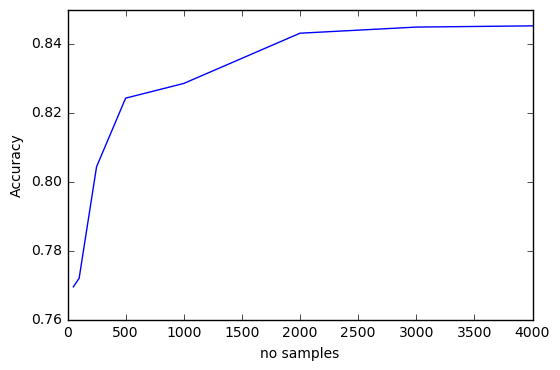

In [50]:
plt.plot(sample_array, logistic_score)
plt.xlabel('no samples')
plt.ylabel('Accuracy')

In [52]:
from sklearn.grid_search import GridSearchCV
sample_size = 2000
print "Sample size %d \n" %sample_size
X_train = train_dataset[:sample_size].reshape(sample_size, image_width * image_height)
y_train = train_labels[:sample_size]

param_grid = {'Cs': [1, 5, 10],
              'fit_intercept': [True, False],
              'cv': [2]}
              # 'penalty': ['l1','l2']}
clf = GridSearchCV(regr, param_grid)
clf.fit(X_train,y_train)

Sample size 2000 



GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegressionCV(Cs=10, class_weight=None, cv=2, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=2, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'Cs': [1, 5, 10], 'cv': [2], 'fit_intercept': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [53]:
# Get the estimator
print clf.best_estimator_
 

# Report the final F1 score for training and testing after parameter tuning
print "Tuned model has a training F1 score of {:.4f}.".format(predict_labels(clf, X_train, y_train))
print "Tuned model has a testing F1 score of {:.4f}.".format(predict_labels(clf, X_test, y_test))

LogisticRegressionCV(Cs=10, class_weight=None, cv=2, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=2, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)


NameError: name 'predict_labels' is not defined

In [54]:
sample_size = 2000
print "Sample size %d \n" %sample_size
X_train = train_dataset[:sample_size].reshape(sample_size,image_width * image_height)
y_train = train_labels[:sample_size]
#%time regr.fit(X_train, y_train)
print(clf.score(X_test, y_test))

Sample size 2000 

0.833866951263


In [57]:
sample_array = [50, 100, 250, 500, 1000, 2000, 3000, 4000]
logistic_score = []
pred_valid = []
for sample_size in sample_array:
    print "Sample size %d \n" %sample_size
    X_train = train_dataset[:sample_size].reshape(sample_size, image_width * image_height)
    y_train = train_labels[:sample_size]
    %time clf.fit(X_train, y_train)
    pred_valid.append(clf.predict(X_valid))
    logistic_score.append(clf.score(X_valid, y_valid))
    print "\n"

Sample size 50 

CPU times: user 3.97 s, sys: 6.38 s, total: 10.3 s
Wall time: 8.11 s


Sample size 100 

CPU times: user 4.54 s, sys: 7.28 s, total: 11.8 s
Wall time: 10.2 s


Sample size 250 

CPU times: user 7.91 s, sys: 8.89 s, total: 16.8 s
Wall time: 17.5 s


Sample size 500 

CPU times: user 15.4 s, sys: 10.8 s, total: 26.2 s
Wall time: 30.6 s


Sample size 1000 

CPU times: user 30.5 s, sys: 13.1 s, total: 43.6 s
Wall time: 53.4 s


Sample size 2000 

CPU times: user 55.2 s, sys: 16.8 s, total: 1min 11s
Wall time: 1min 49s


Sample size 3000 

CPU times: user 1min 29s, sys: 21.5 s, total: 1min 51s
Wall time: 2min 53s


Sample size 4000 

CPU times: user 1min 58s, sys: 24.1 s, total: 2min 22s
Wall time: 3min 40s




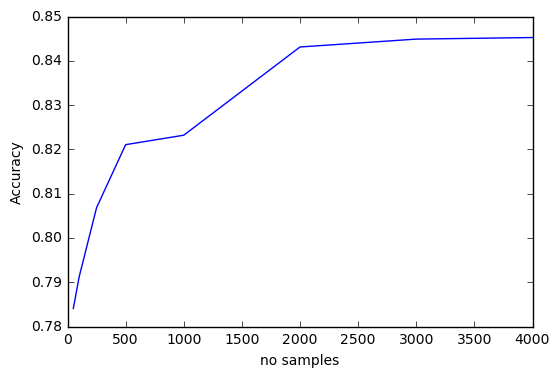

In [59]:
plt.plot(sample_array, logistic_score)
plt.xlabel('no samples')
plt.ylabel('Accuracy')